In [1]:
import tensorflow as tf

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-23 09:06:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-23 09:06:33 (89.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

---

## Verileri İndirmek için TensorFlow Veri Kümelerini Kullanın

Önceki not defterlerinde, Google Storage'dan yiyecek resimlerimizi (Food101 veri kümesinden) indirmiştik.

Ve bu, kendi veri kümeleriniz üzerinde çalışıyorsanız kullanacağınız tipik bir iş akışıdır.

Ancak, veri kümelerini TensorFlow ile kullanıma hazır hale getirmenin başka bir yolu daha var.

Makine öğrenimi dünyasındaki en popüler veri kümelerinin çoğu için (genellikle kıyaslama olarak anılır ve kullanılır), bunlara TensorFlow Veri Kümeleri (TFDS) aracılığıyla erişebilirsiniz.

**TensorFlow Veri Kümeleri nedir?**

Hazırlanmış ve kullanıma hazır makine öğrenimi veri kümeleri için bir yer.

Neden TensorFlow Veri Kümelerini kullanmalısınız?

- Verileri zaten Tensörlerde yükleyin
- İyi kurulmuş veri kümeleri üzerinde pratik yapın
- Farklı veri yükleme teknikleriyle denemeler yapın (bu not defterinde kullanacağımız gibi)
- Yeni TensorFlow özelliklerini hızlı bir şekilde deneyin (karma hassas eğitim gibi)

Neden TensorFlow Veri Kümelerini kullanmıyorsunuz?

- Veri kümeleri statiktir (gerçek dünyadaki veri kümeleriniz gibi değişmezler)
- Özel probleminiz için uygun olmayabilir (ancak deneme için harika)

TensorFlow Veri Kümelerini kullanmaya başlamak için onu tfds takma adı altında içe aktarabiliriz.

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

TensorFlow Veri Kümelerinde mevcut tüm veri kümelerini bulmak için list_builders() yöntemini kullanabilirsiniz.

Bunu yaptıktan sonra, peşinde olduğumuz kişinin ("food101") olup olmadığını kontrol edebiliriz.

In [5]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


Güzel! Peşinde olduğumuz veri kümesi mevcut gibi görünüyor (daha fazlasının mevcut olduğunu unutmayın, ancak biz Food101'deyiz).

TFDS'den Food101 veri setine erişmek için tfds.load() yöntemini kullanabiliriz.

Özellikle, neyin peşinde olduğumuzu bilmesi için ona birkaç parametre iletmemiz gerekecek:

- name (str) : hedef veri seti (ör. "food101")
- split (liste, isteğe bağlı) : peşinde olduğumuz veri kümesinin hangi bölümleri (ör. ["train", "validation"])
split parametresi oldukça zor. Daha fazlası için belgelere bakın.
- shuffle_files (bool): İndirme sırasında dosyaların karıştırılıp karıştırılmayacağı, varsayılan olarak False olur
- as_supervised (bool) : Veri örneklerini grup biçiminde ((veri, etiket)) veya Sözlük biçiminde False olarak indirmek için doğru
- with_info (bool): Veri kümesi meta verilerini indirmek için doğru (etiketler, örnek sayısı, vb.)

> 🔑 Not: download=True parametresi ayarlanmışsa (varsayılan) tfds.load() yönteminin çağrılması, diske hedef veri kümesini indirmeye başlar. Bu veri kümesi 100GB+ olabilir, bu nedenle alanınız olduğundan emin olun.

In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteVZ4UW0/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteVZ4UW0/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Olağanüstü! Birkaç dakika indirdikten sonra, modellemeye hazır tüm Food101 veri setine (tensör formatında) erişebiliriz.

Şimdi veri setimizden sınıf isimlerinden başlayarak biraz bilgi alalım.

Bir TensorFlow Veri Kümeleri veri kümesinden sınıf adları almak, "dataset_info" değişkeninin indirilmesini gerektirir (tfds.load() yönteminde as_supervised=True parametresini kullanarak, not: bu yalnızca TFDS'deki denetlenen veri kümeleri için çalışır).

Belirli bir veri kümesinin sınıf adlarına dataset_info.features özniteliğini ve "label" anahtarının erişim adları özniteliğini kullanarak erişebiliriz.

In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## TensorFlow Veri Kümelerinden Food101 verilerini keşfetme

Şimdi TensorFlow Veri Kümelerinden Food101 veri kümesini indirdik, iyi bir veri gezgininin yapması gerekeni yapmaya ne dersiniz?

Başka bir deyişle, "görselleştir, görselleştir, görselleştir".

Veri kümemiz hakkında birkaç ayrıntı öğrenelim:

- Girdi verilerimizin şekli (görüntü tensörleri)
- Giriş verilerimizin veri türü
- Girdi verilerimizin etiketleri nasıl görünür (ör. tek sıcak kodlanmış ve etiket kodlanmış)
- Etiketler sınıf adlarıyla eşleşiyor mu?

Bunu yapmak için, eğitim verilerinden bir örnek alalım ([.take()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) yöntemini kullanarak) ve onu keşfedelim.

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Yukarıdaki `tfds.load()` yöntemimizde `as_supervised=True` parametresini kullandığımız için, veri örnekleri tanımlama grubu biçiminde (veri, etiket) veya bizim durumumuzda (image_tensor, etiket) gelir.

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

Tek eğitim örneğimizi gözden geçirelim ve image_tensor ve etiketten biraz bilgi alalım.

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
        


Yukarıdaki tfds.load() yöntemimizde shuffle_files=True parametresini ayarladığımız için, yukarıdaki hücreyi birkaç kez çalıştırmak her seferinde farklı bir sonuç verecektir.

Bunları kontrol ettiğinizde bazı resimlerin farklı şekillerde olduğunu fark edebilirsiniz, örneğin (512, 342, 3) ve (512, 512, 3) (yükseklik, genişlik, renk_kanalları).

TFDS'nin Food101 veri setindeki görüntü tensörlerinden birinin neye benzediğini görelim.

In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [13]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Pekala, görüntü tensörlerimizin 0 ve 255 (standart kırmızı, yeşil, mavi renk değerleri) arasında değerlere sahip olduğu ve değerlerin birim8 veri tipinde olduğu görülüyor.

Bunları bir sinir ağına geçirmeden önce ön işleme koymamız gerekebilir. Ama bunu daha sonra halledeceğiz.

Bu arada, bir resim örneği çizebilecek miyiz bakalım.

## TensorFlow Veri Kümelerinden bir görüntü çizin

Görüntü tensörlerimizi tensör formatında gördük, şimdi gerçekten sloganımıza bağlı kalalım.

"Görselleştirin, görselleştirin, görselleştirin!"

matplotlib.pyplot.imshow() kullanarak resim örneklerinden birini çizelim ve başlığı hedef sınıf adına ayarlayalım.

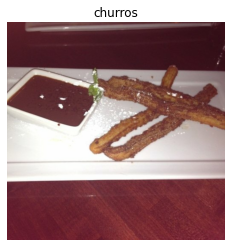

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Lezzetli!

Tamam, TFDS'den aldığımız Food101 verileri, önceki defterlerde kullandığımız veri kümelerine benziyor gibi görünüyor.

Şimdi önişleme yapalım ve bir sinir ağı ile kullanıma hazır hale getirelim.

## Verilerimiz için ön işleme işlevleri oluşturun

Önceki defterlerde, resimlerimiz klasör biçimindeyken, onları yüklemek için tf.keras.preprocessing.image_dataset_from_directory() yöntemini kullanırdık.

Bunu yapmak, verilerimizin modellerimizle kullanılmaya hazır bir formata yüklenmesi anlamına geliyordu.

Ancak verileri TensorFlow Veri Kümelerinden indirdiğimiz için, modellemeye hazır olmadan önce gerçekleştirmemiz gereken birkaç ön işleme adımı vardır.

Daha spesifik olarak, verilerimiz şu anda:
- uint8 veri türünde
- Tüm farklı boyuttaki tensörlerden oluşur (farklı boyutlu görüntüler)
- Ölçeklendirilmemiş (piksel değerleri 0 ile 255 arasındadır)

Oysa modeller verileri sever:
- float32 veri türünde
- Tüm tensörlerin tümü aynı boyutta olsun (partiler, tüm tensörlerin aynı şekle sahip olmasını gerektirir, örneğin (224, 224, 3))
- Ölçekli (0 ve 1 arasındaki değerler), normalleştirilmiş olarak da adlandırılır

Bunlarla ilgilenmek için bir `preprocess_img()` işlevi oluşturacağız ve bu işlev:
- tf.image.resize() kullanarak bir giriş görüntüsü tensörünü belirtilen bir boyuta yeniden boyutlandırır
- tf.cast() kullanarak bir girdi görüntüsü tensörünün mevcut veri tipini tf.float32'ye dönüştürür

> 🔑 Not: Önceden eğitilmiş EfficientNetBX modellerinde tf.keras.applications.protectionnet yerleşik olarak yeniden ölçeklendirmeye sahiptir. Ancak diğer birçok model mimarisi için verilerinizi yeniden ölçeklendirmek isteyeceksiniz (örneğin, değerlerini 0 ve 1 arasında alın). Bu, "preprocess_img()" işlevinizin içine (aşağıdaki gibi) veya modelinizin içine bir [tf.keras.layers.experimental.preprocessing.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) katmanı olarak dahil edilebilir.

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Yukarıdaki preprocess_img() fonksiyonumuz, veri setimiz şu anda demet yapısında (image, label) olduğundan (etikete hiçbir şey yapmasa da) girdi olarak görüntü ve etiketi alır.

Fonksiyonumuzu bir hedef görüntü üzerinde deneyelim.

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Mükemmel! Görünüşe göre preprocess_img() fonksiyonumuz beklendiği gibi çalışıyor.

Giriş görüntüsü uint8'den float32'ye dönüştürülür ve mevcut şeklinden (224, 224, 3) şeklinde yeniden şekillendirilir.

Nasıl gözüküyor?

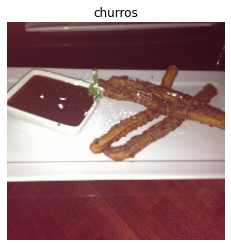

In [17]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

Bütün bu yemek görselleştirmesi beni acıktırıyor. Onu modellemeye hazırlanmaya başlasak nasıl olur?

## Veri kümelerini toplu olarak hazırlayın

Verilerimizi modellemeden önce, onu yığınlara dönüştürmeliyiz.

Neden?

Çünkü toplu işlemlerde bilgi işlem bellek açısından verimlidir.

Verilerimizi 101.000 görüntü tensörü ve etiketinden (birlikte eğitme ve test etme) 32 görüntü ve etiket çiftinden oluşan yığınlara dönüştürüyor ve böylece GPU'muzun belleğine sığmasını sağlıyoruz.

Bunu etkili bir şekilde yapmak için, tf.data API'sinden bir dizi yöntemden yararlanacağız.

📖 Kaynak: Verileri mümkün olan en performanslı şekilde yüklemek için, tf.data API ile daha iyi performans hakkındaki TensorFlow belgelerine bakın.

Spesifik olarak, şunları kullanacağız:

- map() - önceden tanımlanmış bir işlevi hedef veri kümesine eşler (örneğin, preprocess_img() görüntü tensörlerimize)
- shuffle() - tampon_boyutu hedef veri kümesinin öğelerini rastgele karıştırır (ideal olarak, arabellek_boyutu veri kümesinin boyutuna eşittir, ancak bunun bellek üzerinde etkileri olabilir)
- batch() - bir hedef veri kümesinin öğelerini toplu işlere dönüştürür (batch_size parametresi tarafından tanımlanan boyut)
- prefetch() - diğer veri grupları hesaplanırken sonraki veri gruplarını hazırlar (veri yükleme hızını artırır ancak belleğe mal olur)
- Ekstra: cache() - öğeleri hedef veri kümesinde önbelleğe alır (onları daha sonra kaydeder), yükleme süresinden tasarruf sağlar (yalnızca veri kümeniz belleğe sığacak kadar küçükse çalışır, standart Colab örnekleri yalnızca 12 GB belleğe sahiptir)

Dikkat edilmesi gerekenler:

- Farklı şekillerdeki tensörleri gruplayamazsınız (örneğin, farklı görüntü boyutları, önce görüntüleri yeniden şekillendirmeniz gerekir, bu nedenle preprocess_img() işlevimiz)
- shuffle(), görüntüleri karıştırarak ilettiğiniz sayının bir arabelleğini tutar, ideal olarak bu sayı, eğitim setinizdeki tüm örnekler olacaktır, ancak, eğitim setiniz büyükse, bu arabellek belleğe sığmayabilir (oldukça büyük bir sayı 1000 veya 10000 gibi genellikle karıştırma için yeterlidir)
- num_parallel_calls parametresi mevcut olan (map() gibi) yöntemler için, num_parallel_calls=tf.data.AUTOTUNE ayarının yapılması ön işlemeyi paralel hale getirecek ve hızı önemli ölçüde artıracaktır.
- Veri kümeniz belleğe sığmadıkça cache() kullanılamaz

Woah, yukarıdakiler çok fazla. Ancak aşağıda kodladığımızda, mantıklı gelmeye başlayacak.

Aşağıdaki sırayla şeyler üzerinden gidiyoruz:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

Bu, şunu söylemek gibidir:
> "Hey, bu ön işleme işlevini eğitim veri kümemizde eşleştirin, ardından bir dizi öğeyi bir araya getirmeden önce karıştırın ve model mevcut toplu işlere bakarken yeni gruplar (ön getirme) hazırladığınızdan emin olun".

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png" />

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Mükemmel! Görünüşe göre verilerimiz şimdi `(tf.float32, tf.int64)` veri türleriyle `(image, label)` kümelerinde, tam da modelimizin peşinde olduğu şey.

> 🔑 Not: Veri kümelerinizin sonunda prefetch() yöntemini çağırmadan kurtulabilirsiniz, ancak bir model oluştururken muhtemelen önemli ölçüde daha yavaş veri yükleme hızları görürsünüz. Bu nedenle, veri kümesi girdi işlem hatlarınızın çoğu, prefecth() çağrısıyla bitmelidir.


## Modelleme geri aramaları oluşturun

Büyük miktarda veri üzerinde eğitim yapacağımızdan ve eğitim uzun zaman alabileceğinden, modelimizin eğitim günlüklerinin izlendiğinden ve modelimizin denetlendiğinden emin olmak için bazı modelleme geri aramaları ayarlamak iyi bir fikirdir. (kaydedildi) çeşitli eğitim kilometre taşlarından sonra.

Bunların her birini yapmak için aşağıdaki geri aramaları kullanacağız:

- tf.keras.callbacks.TensorBoard() - daha sonra inceleyebilmemiz için modelimizin eğitim geçmişini takip etmemizi sağlar (not: bu geri aramayı helper_functions.py'den create_tensorboard_callback() olarak içe aktarmadan önce oluşturduk)
- tf.keras.callbacks.ModelCheckpoint() - modelimizin ilerlemesini çeşitli aralıklarla kaydeder, böylece yeniden eğitmek zorunda kalmadan daha sonra yükleyebilir ve yeniden kullanabiliriz
  - Kontrol noktası da yararlıdır, böylece modelimizde belirli bir çağda ince ayar yapmaya başlayabilir ve ince ayar hiçbir fayda sağlamıyorsa önceki duruma geri dönebiliriz.

In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Karma hassas eğitim ayarlayın

Yukarıda karma hassas eğitime değindik.

Ancak tam olarak anlatamadık.

Normalde, TensorFlow'daki tensörler varsayılan olarak float32 veri tipine göredir (aksi belirtilmedikçe).

Bilgisayar biliminde, float32, tek duyarlıklı kayan nokta biçimi olarak da bilinir. 32, genellikle bilgisayar belleğinde 32 bit kapladığı anlamına gelir.

GPU'nuzun sınırlı bir belleği vardır, bu nedenle aynı anda yalnızca birkaç float32 tensörü işleyebilir.

Karma hassas eğitimin geldiği yer burasıdır.

Karma hassas eğitim, GPU'nuzun belleğini daha iyi kullanmak için bir float16 ve float32 tensör karışımı kullanmayı içerir.

Float16'nın ne anlama geldiğini tahmin edebilir misiniz?

Float32'nin tek duyarlıklı kayan nokta anlamına geldiğini düşündüyseniz, float16'nın yarı duyarlıklı kayan nokta biçimi anlamına geldiğini tahmin etmiş olabilirsiniz. Ve eğer yaptıysanız, haklısınız! Ve değilse, sorun değil, şimdi biliyorsun.

Float16 formatındaki tensörler için, her eleman bilgisayar belleğinde 16 bit kaplar.

Peki, bu bizi nereye bırakıyor?

Daha önce belirtildiği gibi, karma hassas eğitim kullanırken, modeliniz mümkün olduğunda daha az bellek kullanmak ve daha hızlı çalışmak için float32 ve float16 veri türlerini kullanır (tensör başına daha az bellek kullanmak, aynı anda daha fazla tensörün hesaplanabileceği anlamına gelir).

Sonuç olarak, karma hassas eğitim kullanmak, modern GPU'larda (işlem yeteneği puanı 7.0+ olanlar) performansınızı 3 kata kadar artırabilir.

Daha ayrıntılı bir açıklama için [TensorFlow karma](https://www.tensorflow.org/guide/mixed_precision) kesinlik kılavuzunu okumanızı tavsiye ederim (en azından özete göz atmanızı şiddetle tavsiye ederim).

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png" />

Karma hassas eğitim, float32 ve float16 veri türlerinin bir kombinasyonunu kullandığından, modern GPU'larda 3 kata kadar hızlanma görebilirsiniz.

> 🔑 Not: GPU'nuzun puanı 7.0+ üzerinde değilse (örneğin Colab'da P100), karma hassasiyet çalışmaz (daha fazlası için karma hassasiyet kılavuzunda "[Desteklenen Donanım](https://www.tensorflow.org/guide/mixed_precision#supported_hardware)" bölümüne bakın).

> 📖 Kaynak: Bilgisayar bilimlerinde kesinlik (sayısal bir miktarın bilgisayar tarafından ifade edildiği ayrıntı) hakkında daha fazla bilgi edinmek isterseniz, Wikipedia sayfasına (ve beraberindeki kaynaklara) bakın.

Tamam, yeterince konuşma, TensorFlow'da karma hassas eğitimi nasıl açabileceğimizi görelim.

Güzel olan şey, tensorflow.keras.mixed_precision API'sinin başlamamızı çok kolaylaştırmasıdır.

İlk önce API'yi içe aktaracağız ve ardından dtype politikasını "mixed_float16" olarak ayarlamak için set_global_policy() yöntemini kullanacağız.

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Güzel! Kullanmakta olduğunuz GPU, 7.0+ işlem kapasitesine sahip olduğu sürece, yukarıdaki hücre hatasız çalışmalıdır.

Şimdi genel dtype politikasını (modelimizde katmanlar tarafından kullanılacak olan politika) [tf.keras.mixed_precision.global_policy
()](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) yöntemini kullanarak kontrol edebiliriz.

In [22]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

Harika, global dtype politikası artık "mixed_float16" olduğundan, modelimiz mümkün olduğunda otomatik olarak float16 değişkenlerinden yararlanacak ve dolayısıyla eğitimi hızlandıracaktır.

## Özellik çıkarma modeli oluştur

Geri aramalar: yuvarlanmaya hazır.

Karışık hassasiyet: açık.

Bir model oluşturalım.

Veri kümemiz oldukça büyük olduğundan, önceden eğitilmiş mevcut bir modele (EfficienetNetB0) ince ayar yapmaya doğru ilerleyeceğiz.

Ancak ince ayara geçmeden önce, bir özellik çıkarma modeli oluşturalım.

Hatırlayın, transfer öğrenmeyi kullanmanın tipik sırası:

1. Bir özellik çıkarma modeli oluşturun (önceden eğitilmiş bir modelin ilk birkaç katmanını değiştirin)
2. Alt katmanları donmuş olarak birkaç dönem boyunca eğitin
3. Dondurulmamış birden çok katmanla gerekirse ince ayar yapın

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png" />

Özellik çıkarma modelini oluşturmak için (TensorFlow Bölüm 1: Özellik çıkarmada Aktarım Öğrenimi kapsamında ele alınmıştır), şunları yapacağız:

- Temel modelimiz olarak ImageNet üzerinde önceden eğitilmiş tf.keras.applications'dan EfficientNetB0'ı kullanın
  - Kendi çıktı katmanlarımızı oluşturabilmemiz için bunu include_top=False parametresini kullanarak üst katmanlar olmadan indireceğiz
- Temel model katmanlarını dondurun, böylece temel modelin ImageNet'te bulduğu önceden öğrenilmiş kalıpları kullanabiliriz.
- İşlevsel bir modelde girdi, temel model, havuzlama ve çıktı katmanlarını bir araya getirin
- Kayıp işlevi olarak Adam optimize edici ve [Sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) entropiyi kullanarak İşlevsel modeli derleyin (etiketlerimiz tek sıcak olarak kodlanmadığından)
- TensorBoard ve ModelCheckpoint geri aramalarını kullanarak modeli 3 döneme sığdırın

> 🔑 Not: Karma hassas eğitim kullandığımızdan, modelimizin sabit kodlanmış dtype=float32 ile ayrı bir çıktı katmanına ihtiyacı vardır, örneğin,layer.Activation("softmax", dtype=tf.float32). Bu, modelimizin çıktılarının, float16 veri türünden sayısal olarak daha kararlı olan (kayıp hesaplamaları için önemlidir) float32 veri türüne geri döndürülmesini sağlar. Daha fazlası için TensorFlow karma hassasiyet kılavuzundaki ["Modeli oluşturma"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) bölümüne bakın.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png" />

In [23]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 40kB/s 
     |████████████████████████████████| 2.9MB 35.1MB/s 
     |████████████████████████████████| 471kB 14.7MB/s 
     |████████████████████████████████| 3.8MB 19.6MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [24]:
tf.__version__

'2.5.0'

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

TypeError: ignored

In [ ]:
# Check out our model
model.summary()

## Katman türü politikalarını kontrol etme (karma hassasiyet mi kullanıyoruz?)

Model gitmeye hazır!

Karışık hassas API'nin katmanlarımızın dtype politikasını otomatik olarak global dtype politikası ne olursa olsun değiştireceğini söylemeden önce (bizim durumumuzda "mixed_float16").

Bunu, modelimizin katmanlarını ve dtype ve dtype_policy gibi yazdırma katmanı niteliklerini yineleyerek kontrol edebiliriz.

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

Yukarıdakileri incelediğimizde şunu görüyoruz:

- layer.name (str) : bir katmanın insan tarafından okunabilen adı, yapım sırasında name parametresi ile tanımlanabilir
- layer.trainable (bool) : bir katmanın eğitilebilir olup olmadığı (eğitilebilir niteliğini False olarak ayarladığımız için efficentnetb0 katmanı dışında tüm katmanlarımız eğitilebilirdir)
- layer.dtype : bir katmanın değişkenlerini içinde sakladığı veri türü
- katman.dtype_policy : bir katmanın hesapladığı veri türü

> 🔑 Not: Bir katman, değişkenlerini (ağırlıklar ve önyargılar) float32'de (sayısal olarak daha kararlı) sakladığı için, ancak float16'da (daha hızlı) hesapladığı için, bir float32 tipine ve bir "mixed_float16" tip politikasına sahip olabilir.

Aynı detayları modelimizin temel modeli için de kontrol edebiliriz.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

> 🔑 Not: Karışık kesinlik API'si, onu kullanmak için "mixed_float16" dtype ilkesini kullanmaktan yararlanabilecek katmanlara otomatik olarak neden olur. Ayrıca, onu kullanmaması gereken katmanların (örneğin, temel modelin başlangıcındaki normalleştirme katmanı) kullanmasını engeller.

## Özellik çıkarma modelini sığdır

Şimdi bu iyi görünümlü bir model. Verilerimize uyduralım mı?

Üst katmanlarımızın ağırlıklarını gıda görüntü verilerimize göre ayarlaması için üç dönem yeterli olmalıdır.

Dönem başına zamandan tasarruf etmek için ayrıca test verilerinin yalnızca %15'ini doğrulayacağız.

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Güzel, görünüşe göre özellik çıkarma modelimiz oldukça iyi performans gösteriyor. Bunu tüm test veri setinde değerlendirmeye ne dersiniz?

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

ModelCheckpoint geri aramasını kullandığımızdan, model_checkpoints dizininde modelimizin kayıtlı bir versiyonuna sahibiz.

Onu yükleyelim ve aynı şekilde performans gösterdiğinden emin olalım.

## Kontrol noktası ağırlıklarını yükleyin ve değerlendirin

Modelimizin kontrol noktalarını şu şekilde yükleyebilir ve değerlendirebiliriz:

1. Sıfırlama ağırlıkları ile özellik çıkarma modelimizin bir kopyasını oluşturmak için tf.keras.models.clone_model() kullanarak modelimizi klonlamak.
2. Klonlanmış modelimizde load_weights() yöntemini çağırmak, kontrol noktası ağırlıklarımızın depolandığı yolu iletmek.
3. Yüklenen ağırlıklarla klonlanmış modelde evaluate() çağrılıyor.

Bir hatırlatma, kontrol noktaları, modelinizde ince ayar yapmak gibi bir deney yaptığınızda yardımcı olur. Özellik çıkarma modelinizde ince ayar yapmanız ve bunun herhangi bir iyileştirme sağlamadığını fark etmeniz durumunda, modelinizin kontrol noktalı sürümüne her zaman geri dönebilirsiniz.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

Modelinizde her değişiklik yaptığınızda (yükleme ağırlıkları dahil), yeniden derlemeniz gerekir.

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

Yüklenen ağırlık sonuçlarına sahip klonlanmış modelimiz, özellik çıkarma modelinin sonuçlarına çok yakın olmalıdır (eğer aşağıdaki hücrede hata varsa, bir şeyler ters gitti).

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all() # check if all elements in array are close

Modeli klonlamak, dtype_policy'nin katmanlarını korur (ancak ağırlıkları korumaz), bu nedenle klonlanmış modelle ince ayar yapmaya devam etmek istiyorsak, karma hassas dtype politikasını kullanabilirdik ve kullanmaya devam ederdi.

## Tüm modeli dosyaya kaydedin

Ayrıca save() metodunu kullanarak tüm modeli kaydedebiliriz.

Modelimiz oldukça büyük olduğundan, daha sonra kullanmak üzere yükleyebilmek için (Google Colab kullanıyorsanız) Google Drive'a kaydetmek isteyebilirsiniz.

> 🔑 Not: Google Drive'a kaydetme, Google Drive'ın kurulmasını gerektirir (Dosyalar -> Drive'ı Bağla'ya gidin).

In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Bir SavedModel yüklemek aynı zamanda dtype_policy altında yatan tüm katmanları da korur ("mixed_float16" olmalarını istiyoruz).

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

İstediğimiz bu! Yüklenen modelimiz olması gerektiği gibi çalışıyor.

> 🔑 Not: Modelimizin doğru bir şekilde kaydedildiğinden emin olmak için oldukça zaman harcadık çünkü çok fazla veri üzerinde eğitim almak zaman alabilir, bu yüzden sürekli olarak sıfırdan eğitim yapmamız gerekmediğinden emin olmak istiyoruz.

## Modelimizin katmanlarını ince ayar için hazırlama

Özellik çıkarma modelimiz, üç çağdan sonra büyük umut vaat ediyor. Ancak elimizde çok fazla veri olduğu için, ince ayar ile hangi sonuçları elde edebileceğimizi görmemiz muhtemelen faydalı olacaktır (ince ayar, genellikle oldukça fazla miktarda veriye sahip olduğunuzda en iyi sonucu verir).

DeepFood gazetesini geçme hedefimizi hatırlıyor musunuz?

2-3 günlük eğitim boyunca Food101'de %77.4 ilk 1 doğruluk elde etmeyi başardılar.

Sence ince ayar bizi oraya götürür mü?

Hadi bulalım.

Başlamak için kayıtlı modelimizi yükleyelim.

> 🔑 Not: İnce ayar için geleneksel bir iş akışının, önceden eğitilmiş bir temel modeli dondurmak ve ardından yalnızca çıktı katmanlarını birkaç yineleme için eğitmek olduğunu hatırlamaya değer, böylece ağırlıkları özel verilerinizle (özellik çıkarma) aynı hizada güncellenebilir. Ardından, temel modeldeki bir dizi veya tüm katmanları çözün ve modelin gelişimi durana kadar eğitime devam edin.

Tüm iyi yemek programları gibi, daha önce hazırladığım bir modeli (yukarıdan özellik çıkarma modeli) Google Storage'a kaydettim.

İleride aynı modeli kullandığımızdan emin olmak için indirebiliriz.

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Ve şimdi yüklü modelimizin beklendiği gibi performans gösterdiğinden emin olalım.

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

Harika, yüklü modelimiz beklendiği gibi çalışıyor.

Modelimizi ilk oluşturduğumuzda base_model.trainable=False olarak temel modeldeki tüm katmanları dondurduk ama modelimize dosyadan yüklediğimiz için katmanların eğitilebilir olup olmadığını kontrol edelim.

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

Pekala, yüklü modelimizdeki her katman eğitilebilir gibi görünüyor. Peki ya biraz daha derine inip temel modelimizde katmanların her birini incelersek?

> 🤔 Soru: Yüklenen modeldeki hangi katman bizim temel modelimiz?

İşlevsel modeli dosyaya kaydetmeden önce, onu beş katmanla oluşturduk (aşağıdaki katmanlar 0 dizinlidir):

0. giriş katmanı
1. Önceden eğitilmiş temel model katmanı (tf.keras.applications.EfficientNetB0)
2. havuzlama katmanı
3. Tam bağlantılı (yoğun) katman
4. Çıkış softmax aktivasyonu (float32 dtype ile)

Bu nedenle, temel model katmanımızı incelemek için, modelimizde dizin 1'deki katmanın katmanlar özniteliğine erişebiliriz.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Harika, temel modelimizdeki her katman eğitilebilir (dondurulmamış) gibi görünüyor ve "mixed_policy16" dtype politikasını kullanması gereken her katman onu kullanıyor.

Çok fazla veriye sahip olduğumuz için (750 görüntü x 101 eğitim sınıfı = 75750 eğitim görüntüsü), temel modelimizin tüm katmanlarını donmamış halde tutalım.

🔑 Not: Az miktarda veriye sahipseniz (sınıf başına 100 görüntüden az), bir kerede temel modelde yalnızca az sayıda katmanı çözmek ve ince ayar yapmak isteyebilirsiniz. Aksi takdirde, aşırı uyum riskiyle karşı karşıya kalırsınız.

## Birkaç geri arama daha

100.000'den fazla (75k+ eğitim, 25K+ test) görüntü kullanarak 200'den fazla katman içeren bir derin öğrenme modelinde ince ayar yapmaya başlamak üzereyiz, bu da modelimizin eğitim süresinin muhtemelen eskisinden çok daha uzun olacağı anlamına geliyor.

🤔 Soru: Eğitim ne kadar sürer?

Birkaç saat olabilir veya DeepFood makalesi (geçmeye çalıştığımız temel çizgi) söz konusu olduğunda, en iyi performans gösteren modelleri 2-3 günlük eğitim süresi aldı.

Gerçekten sadece antrenmana başladığınızda ne kadar süreceğini bileceksiniz.

🤔 Soru: Antrenmanı ne zaman bırakıyorsunuz?

İdeal olarak, modeliniz gelişmeyi bıraktığında. Ancak yine, derin öğrenmenin doğası gereği, bir modelin tam olarak ne zaman gelişmeyi bırakacağını bilmek zor olabilir.

Neyse ki bir çözüm var: EarlyStopping geri araması.

EarlyStopping geri çağırma, belirli bir model performans metriğini (ör. val_loss) izler ve belirli sayıda dönem için iyileştirmeyi bıraktığında eğitimi otomatik olarak durdurur.

En iyi performans gösteren modeli otomatik olarak kaydeden ModelCheckpoint geri araması ile birlikte EarlyStopping geri aramasını kullanarak, model eğitimimizi geliştirmeyi durdurana kadar sınırsız sayıda dönem boyunca tutabiliriz.

Modelimizin val_loss'unu izlemek için ikisini de ayarlayalım.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Woohoo! İnce ayarlı geri aramalar hazır.

Büyük modelleri eğitmeyi planlıyorsanız, ModelCheckpoint ve EarlyStopping çok aşina olmak isteyeceğiniz iki geri aramadır.

Modelimize ince ayar yapmaya başlamak için neredeyse hazırız ancak uygulayacağımız bir geri arama daha var: ReduceLROnPlateau.

Öğrenme oranının, ayarlayabileceğiniz en önemli model hiperparametresi olduğunu hatırlıyor musunuz? (değilse, bunu bir hatırlatma olarak kabul edin).

Eh, ReduceLROnPlateau geri araması, sizin için öğrenme oranını ayarlamanıza yardımcı olur.

ModelCheckpoint ve EarlyStopping geri çağrıları gibi, ReduceLROnPlateau geri çağrısı da belirli bir metriği izler ve bu metrik gelişmeyi bıraktığında, öğrenme oranını belirli bir faktör kadar azaltır (örneğin, öğrenme oranını 10'a böler).

🤔 Soru: Öğrenme oranını neden düşürelim?

Kanepenin arkasında bir bozuk para olduğunu ve parmaklarınızla tutmaya çalıştığınızı hayal edin.

Şimdi öğrenme oranını, elinizin madeni paraya doğru yaptığı hareketlerin büyüklüğü olarak düşünün.

Yaklaştıkça el hareketlerinizin küçülmesini istersiniz, aksi takdirde jeton kaybolur.

Modelimizin ideal performansı madeni parayı kapmakla eşdeğerdir. Eğitim devam ettikçe ve modelimiz ideal performansına (yakınsama olarak da adlandırılır) yaklaştıkça, öğrendiği miktarın giderek daha az olmasını istiyoruz.

Bunu yapmak için, EarlyStopping geri çağrısı gibi, doğrulama kaybını izlemek için bir ReduceLROnPlateau geri çağrısı örneği oluşturacağız.

Doğrulama kaybı iki veya daha fazla dönem için gelişmeyi bıraktığında, öğrenme oranını 5 kat azaltacağız (ör. 0,001 ila 0,0002).

Ve öğrenme oranının çok düşmemesini (ve potansiyel olarak modelimizin hiçbir şey öğrenmemesine yol açmamasını) sağlamak için minimum öğrenme oranını 1e-7 olarak ayarlayacağız.

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Öğrenme oranı indirimi başlamaya hazır!

Şimdi eğitime başlamadan önce modelimizi yeniden derlememiz gerekiyor.

Kayıp olarak seyrek kategorik çapraz entropi kullanacağız ve ince ayar yaptığımız için Adam optimize edici varsayılanından 10 kat daha düşük bir öğrenme oranı kullanacağız (1e-3 yerine 1e-4).

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

Tamam, model derlendi.

Şimdi tüm verilere sığdıralım.

100 çağa kadar çalışacak şekilde ayarlayacağız.

EarlyStopping geri aramasını kullanacağımız için 100 döneme ulaşmadan durabilir.

🔑 Not: Aşağıdaki hücreyi çalıştırmak, modeli tüm Food101 verilerinde temel modelde önceden eğitilmiş tüm ağırlıklara ince ayar yapacak şekilde ayarlayacaktır. Optimize edilmemiş veri ardışık düzenleriyle ve karışık hassasiyet eğitimi olmadan bunu yapmak, kullandığınız GPU türüne bağlı olarak dönem başına oldukça uzun bir zaman alacaktır (Colab GPU'larda yaklaşık 15-20 dakika). Ama merak etmeyin, yukarıda yazdığımız kod çok daha hızlı çalışmasını sağlayacaktır (daha çok dönem başına 4-5 dakika gibi).

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Not: Veri kümelerini Toplu İşle ve hazırla bölümünde karma kesinlik kullanmadıysanız veya prefetch() gibi teknikler kullanmadıysanız, model ince ayarınız muhtemelen dönem başına 2,5-3 kata kadar daha uzun sürer (örnek için aşağıdaki çıktıya bakın).


| | Prefetch and mixed precision | No prefetch and no mixed precision |
|-----|-----|-----|
| Time per epoch | ~280-300s | ~1127-1397s |

```
Saving TensorBoard log files to: training_logs/efficientB0_101_classes_all_data_fine_tuning/20200928-013008
Epoch 1/100
2368/2368 [==============================] - 1397s 590ms/step - loss: 1.2068 - accuracy: 0.6820 - val_loss: 1.1623 - val_accuracy: 0.6894
Epoch 2/100
2368/2368 [==============================] - 1193s 504ms/step - loss: 0.9459 - accuracy: 0.7444 - val_loss: 1.1549 - val_accuracy: 0.6872
Epoch 3/100
2368/2368 [==============================] - 1143s 482ms/step - loss: 0.7848 - accuracy: 0.7838 - val_loss: 1.0402 - val_accuracy: 0.7142
Epoch 4/100
2368/2368 [==============================] - 1127s 476ms/step - loss: 0.6599 - accuracy: 0.8149 - val_loss: 0.9599 - val_accuracy: 0.7373
```

In [ ]:
# # Save model to Google Drive (optional)
# loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

Modelimiz ince ayardan birkaç performans puanı kazanmış gibi görünüyor, hadi tüm test veri setini değerlendirelim ve DeepFood kağıdının %77,4 doğruluk sonucunu geçip geçemediğini görelim.

In [ ]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

Wuhuu!! Modelimiz, DeepFood for Food101 belgesinde belirtilen sonuçları geçmiş gibi görünüyor (DeepFood'un %77,4 ilk 1 doğruluğuna karşı bizim ~%79 ilk 1 doğruluğumuz).